# Part 3 - Damned if you do, damned if you don't 

## Graph and simulate example 4 of Lab7 (Damned if you do damned if you don't)

In [ ]:
import Pkg
Pkg.add("Graphs")
Pkg.add("GraphPlot")
Pkg.add("CairoMakie")
Pkg.add("FilePathsBase")
Pkg.add("Colors")
Pkg.add("Distributions")
Pkg.add("StatsBase")
Pkg.add("DataFrames")
Pkg.add("GLM")
Pkg.add("Plots")
Pkg.add("StatsModels")
Pkg.add("Combinatorics")
Pkg.add("PrettyTables")
Pkg.add("LaTeXStrings")

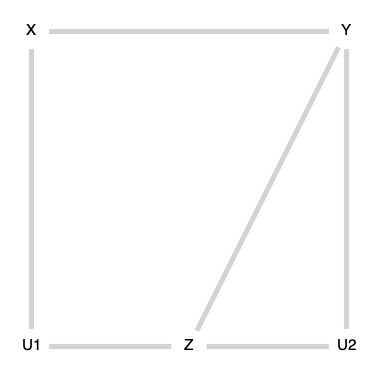

In [15]:
using Graphs
using GraphPlot
using Colors  # importante para colorant"white"

function draw_dag(; save_path::Union{Nothing,String}=nothing, show::Bool=true)
    # Nodos
    nodes = ["U1", "U2", "Z", "X", "Y"]
    node_index = Dict(n => i for (i, n) in enumerate(nodes))

    # Aristas
    edges = [
        ("U1", "X"), ("U1", "Z"),
        ("U2", "Z"), ("U2", "Y"),
        ("X", "Y"), ("Z", "Y")
    ]

    g = DiGraph(length(nodes))
    for (src, dst) in edges
        add_edge!(g, node_index[src], node_index[dst])
    end

    # Posiciones manuales
    pos = Dict(
        "U1" => (-1.0, 1.0),
        "U2" => (1.0, 1.0),
        "Z"  => (0.0, 1.0),
        "X"  => (-1.0, -1.0),
        "Y"  => (1.0, -1.0)
    )
    xy = [pos[n] for n in nodes]
    xs = first.(xy)
    ys = last.(xy)

    # Graficar
    fig = gplot(
        g, xs, ys;
        nodelabel = nodes,
        nodefillc = colorant"white",   # ✅ color válido
        nodesize = 0.2,
        arrowlengthfrac = 0.08,
        arrowangleoffset = 0.5π
    )

    if save_path !== nothing
        savefig(fig, save_path)
    end

    if show
        display(fig)
    end
end

# Uso
draw_dag(show=true)

In [18]:
using Random
using Distributions
using StatsBase   # para sample()

# ------------------------
# 1) Población grande
# ------------------------
N = 1_000_000   # 1 millón
rng = MersenneTwister(123)

# Parámetros
a1, a2 = 1.0, 1.0
b1     = 1.0
τ      = 1.0
c1, c2 = 1.0, 1.0

# Latentes y errores
U1  = randn(rng, N)
U2  = randn(rng, N)
e_z = randn(rng, N)
e_x = randn(rng, N)
e_y = randn(rng, N)

# Construcción de variables
pop_Z = a1 .* U1 .+ a2 .* U2 .+ e_z
pop_X = b1 .* U1 .+ e_x
pop_Y = τ .* pop_X .+ c1 .* pop_Z .+ c2 .* U2 .+ e_y

# ------------------------
# 2) Muestra aleatoria
# ------------------------
n = 5_000
sample_indices = sample(rng, 1:N, n; replace=false)  # ✅ correcto

Y = pop_Y[sample_indices]
X = pop_X[sample_indices]
Z = pop_Z[sample_indices]

5000-element Vector{Float64}:
  0.7847015411514485
 -1.2364755811942647
 -0.28371925773297707
 -0.07015098951426724
  3.4621194506388804
 -0.9536330740937877
  0.7159766201450939
  0.5432596587074427
  0.2595623634714817
  2.791612678214296
 -0.6990287106357541
 -2.874035454691442
  0.5966671727494179
  ⋮
 -0.24128338038432323
 -1.6329575987905438
  0.5271824467539064
 -2.6326017324356377
 -2.4604894063766376
  1.9759529573448749
 -0.08942070660036594
 -2.3214140101195366
  1.0374764638532414
 -0.3916373671050941
 -0.03164372699935014
  1.1030958815586167

## Regress Y vs. X with and without controlling for Z

In [20]:
using DataFrames
using GLM

# Construir DataFrame con las variables
df = DataFrame(Y=Y, X=X, Z=Z)

# ------------------------
# OLS: sin Z (Y ~ X)
# ------------------------
model_omitZ = lm(@formula(Y ~ X), df)

println("=== OLS: Y ~ X (omite Z) ===")
println(coeftable(model_omitZ))

# ------------------------
# OLS: con Z (Y ~ X + Z)
# ------------------------
model_withZ = lm(@formula(Y ~ X + Z), df)

println("\n=== OLS: Y ~ X + Z (controla Z) ===")
println(coeftable(model_withZ))

=== OLS: Y ~ X (omite Z) ===
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  0.0125411   0.0361475   0.35    0.7286  -0.0583239  0.0834061
X            1.51586     0.0254306  59.61    <1e-99   1.46601    1.56572
──────────────────────────────────────────────────────────────────────────

=== OLS: Y ~ X + Z (controla Z) ===
─────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error       t  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  0.000611663   0.0181311    0.03    0.9731  -0.0349332  0.0361565
X            0.794677      0.0140599   56.52    <1e-99   0.767113   0.82224
Z            1.40378       0.011512   121.94    <1e-99   1.38121    1.42634
──────────────────────

## Plot your coefficients associated with X in a single graph like in Part 2. Add this time a horizontal line indicating the true causal effect

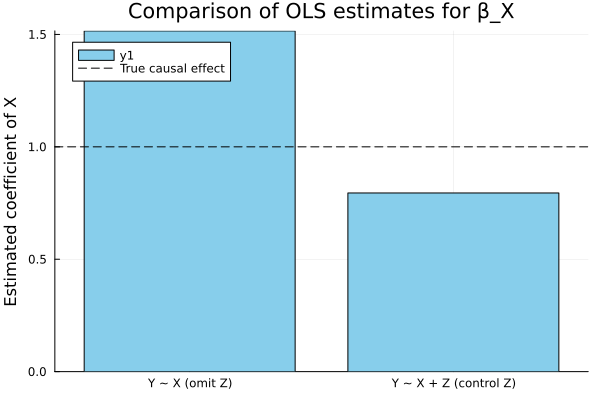

In [22]:
using Plots

# Coeficientes obtenidos en las regresiones (del paso anterior con GLM)
coef_omitZ = coef(model_omitZ)[2]   # beta_X en Y~X
coef_withZ = coef(model_withZ)[2]   # beta_X en Y~X+Z

# Etiquetas y valores
labels = ["Y ~ X (omit Z)", "Y ~ X + Z (control Z)"]
values = [coef_omitZ, coef_withZ]

# Valor verdadero del efecto causal
tau_true = 1.0

# Gráfico
bar(labels, values, 
    color = [:skyblue :salmon], 
    legend = :topleft,
    title = "Comparison of OLS estimates for β_X",
    ylabel = "Estimated coefficient of X")

# Línea horizontal del efecto verdadero
hline!([tau_true], color = :black, linestyle = :dash, label = "True causal effect")

## Now modify the DAG so that Z also has an effect on X. For this part suppose you can observe and control for U1 and U2. Just like in Part 2, you are asked to find a way to get a good estimate with the least number of controls Z, U1, U2.

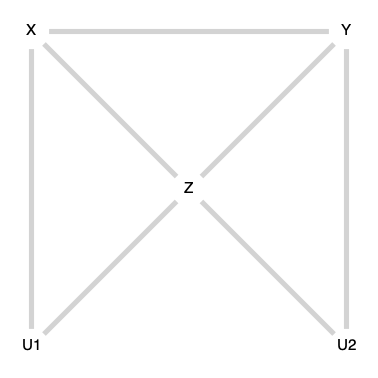

In [23]:
using Graphs
using GraphPlot
using Colors  # para colorant"white"

function draw_dag(; save_path::Union{Nothing,String}=nothing, show::Bool=true)
    # Nodos
    nodes = ["U1", "U2", "Z", "X", "Y"]
    node_index = Dict(n => i for (i, n) in enumerate(nodes))

    # Aristas (con nuevo efecto Z -> X)
    edges = [
        ("U1", "X"), ("U1", "Z"),
        ("U2", "Z"), ("U2", "Y"),
        ("Z", "X"),                  # 🔥 nuevo enlace
        ("X", "Y"), ("Z", "Y")
    ]

    g = DiGraph(length(nodes))
    for (src, dst) in edges
        add_edge!(g, node_index[src], node_index[dst])
    end

    # Posiciones manuales
    pos = Dict(
        "U1" => (-1.0,  1.0),
        "U2" => ( 1.0,  1.0),
        "Z"  => ( 0.0,  0.0),   # lo bajo un poco para que la flecha a X se vea clara
        "X"  => (-1.0, -1.0),
        "Y"  => ( 1.0, -1.0)
    )
    xy = [pos[n] for n in nodes]
    xs = first.(xy)
    ys = last.(xy)

    # Graficar
    fig = gplot(
        g, xs, ys;
        nodelabel = nodes,
        nodefillc = colorant"white",
        nodestrokec = colorant"black",
        nodesize = 0.2,
        arrowlengthfrac = 0.08,
        arrowangleoffset = 0.5π
    )

    if save_path !== nothing
        savefig(fig, save_path)
    end

    if show
        display(fig)
    end
end

# Uso
draw_dag(show=true)

5×5 DataFrame
 Row │ Spec                 beta_X    CI_low    CI_high  Bias        
     │ String               Float64   Float64   Float64  Float64     
─────┼───────────────────────────────────────────────────────────────
   1 │ Y ~ X                1.70301   1.68506   1.72096   0.70301
   2 │ Y ~ X + Z            0.792182  0.766795  0.81757  -0.207818
   3 │ Y ~ X + Z + U1       0.992351  0.960436  1.02427  -0.00764939
   4 │ Y ~ X + Z + U2       1.00688   0.985779  1.02798   0.00687682
   5 │ Y ~ X + Z + U1 + U2  1.00775   0.981929  1.03358   0.00775395


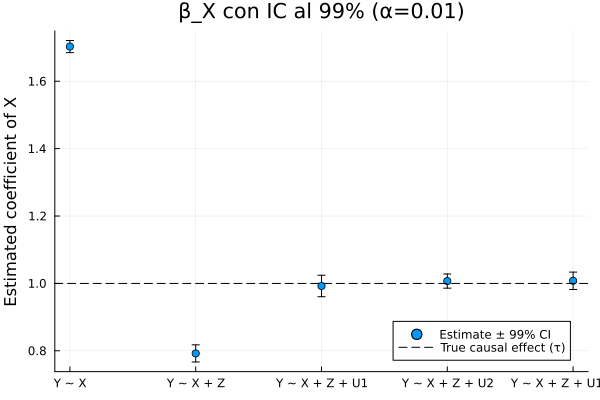

In [31]:
using Random, Distributions
using DataFrames, GLM, StatsBase, StatsModels
using Plots      # para graficar
using CairoMakie # si lo necesitas para otras cosas

# -----------------------------
# 1) Simulación con U1,U2 observables
# -----------------------------
function simulate_once(
    n::Int=5000, seed::Int=123;
    a1::Float64=1.0, a2::Float64=1.0,   # Z <- a1*U1 + a2*U2 + e_z
    b1::Float64=1.0, d1::Float64=1.0,   # X <- b1*U1 + d1*Z + e_x
    τ::Float64=1.0,                     # Y <- τ*X + c1*Z + c2*U2 + e_y
    c1::Float64=1.0, c2::Float64=1.0,
    sig_u::Float64=1.0, sig_ez::Float64=1.0,
    sig_ex::Float64=1.0, sig_ey::Float64=1.0
)
    rng = MersenneTwister(seed)
    U1  = rand(rng, Normal(0, sig_u), n)
    U2  = rand(rng, Normal(0, sig_u), n)
    e_z = rand(rng, Normal(0, sig_ez), n)
    e_x = rand(rng, Normal(0, sig_ex), n)
    e_y = rand(rng, Normal(0, sig_ey), n)

    Z = a1 .* U1 .+ a2 .* U2 .+ e_z
    X = b1 .* U1 .+ d1 .* Z .+ e_x
    Y = τ .* X .+ c1 .* Z .+ c2 .* U2 .+ e_y

    return DataFrame(U1=U1, U2=U2, Z=Z, X=X, Y=Y)
end

# -----------------------------
# 2) OLS con controles opcionales
# -----------------------------
function ols_y_on_x(df::DataFrame; controls::Vector{String}=String[])
    # construir lado derecho de la fórmula
    terms = Term(:X)
    for c in controls
        terms = terms + Term(Symbol(c))
    end
    f = Term(:Y) ~ terms
    return lm(f, df)
end

# -----------------------------
# 3) Simular datos y correr modelos
# -----------------------------
df = simulate_once(10_000, 42)
τ_true = 1.0

specs = [
    ("Y ~ X",                String[]),
    ("Y ~ X + Z",            ["Z"]),
    ("Y ~ X + Z + U1",       ["Z","U1"]),
    ("Y ~ X + Z + U2",       ["Z","U2"]),
    ("Y ~ X + Z + U1 + U2",  ["Z","U1","U2"])
]

results = DataFrame(Spec=String[], beta_X=Float64[],
                    CI_low=Float64[], CI_high=Float64[],
                    Bias=Float64[])

for (name, ctrls) in specs
    m = ols_y_on_x(df; controls=ctrls)
    bx = coef(m)[2]  # coef de X (2do, intercepto es 1ro)

    # Intervalo de confianza 99% (z crítico ≈ 2.576)
    ct = coeftable(m)
    se = ct.cols[2][2]   # Std. Error de X (columna 2, fila 2)
    ci_low = bx - 2.576 * se
    ci_high = bx + 2.576 * se

    push!(results, (name, bx, ci_low, ci_high, bx - τ_true))
end

println(results)

# -----------------------------
# 4) Graficar coeficientes con IC 99%
# -----------------------------
xpos = 1:nrow(results)
y = results.beta_X
yerr_lower = y .- results.CI_low
yerr_upper = results.CI_high .- y

Plots.plot(xpos, y;
     seriestype=:scatter,
     yerror=(yerr_lower, yerr_upper),
     label="Estimate ± 99% CI",
     legend=:bottomright)

Plots.hline!([τ_true], linestyle=:dash, color=:black, label="True causal effect (τ)")
Plots.xticks!(xpos, results.Spec)
Plots.ylabel!("Estimated coefficient of X")
Plots.title!("β_X con IC al 99% (α=0.01)")


## Regress Y vs. X but adding each possible combination of controls from Z, U1, U2 (you should end up running $2^3$ regressions) <n>
## Store the point estimate and standard error of the target parameter in a matrix or dataframe

Total de especificaciones estimadas: 8
8×6 DataFrame
 Row │ Spec                 k_controls  Controls  beta_X    se_X        Bias        
     │ String               Int64       String    Float64   Float64     Float64     
─────┼──────────────────────────────────────────────────────────────────────────────
   1 │ Y ~ X                         0  (none)    1.70301   0.006969     0.70301
   2 │ Y ~ X + U1                    1  U1        1.99091   0.00998306   0.990911
   3 │ Y ~ X + U2                    1  U2        1.49179   0.0048917    0.491786
   4 │ Y ~ X + Z                     1  Z         0.792182  0.00985544  -0.207818
   5 │ Y ~ X + U1 + U2               2  U1,U2     1.49659   0.0084624    0.496587
   6 │ Y ~ X + Z + U1                2  Z,U1      0.992351  0.0123893   -0.00764939
   7 │ Y ~ X + Z + U2                2  Z,U2      1.00688   0.0081903    0.00687682
   8 │ Y ~ X + Z + U1 + U2           3  Z,U1,U2   1.00775   0.010025     0.00775395

Matriz (columnas = [beta_X, se

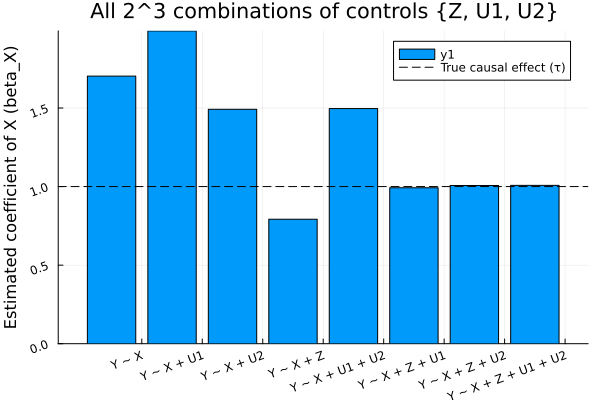

In [35]:
using Random, Distributions
using DataFrames, GLM, StatsModels
using Combinatorics
using Plots

# -----------------------------
# 1) Simulación con U1, U2 observables
# -----------------------------
function simulate_once(
    n::Int=5000, seed::Int=123;
    a1=1.0, a2=1.0,       # Z <- a1*U1 + a2*U2 + e_z
    b1=1.0, d1=1.0,       # X <- b1*U1 + d1*Z + e_x
    τ=1.0,                # Y <- τ*X + c1*Z + c2*U2 + e_y
    c1=1.0, c2=1.0,
    sig_u=1.0, sig_ez=1.0, sig_ex=1.0, sig_ey=1.0
)
    rng = MersenneTwister(seed)
    U1  = rand(rng, Normal(0, sig_u), n)
    U2  = rand(rng, Normal(0, sig_u), n)
    e_z = rand(rng, Normal(0, sig_ez), n)
    e_x = rand(rng, Normal(0, sig_ex), n)
    e_y = rand(rng, Normal(0, sig_ey), n)

    Z = a1 .* U1 .+ a2 .* U2 .+ e_z
    X = b1 .* U1 .+ d1 .* Z .+ e_x
    Y = τ .* X .+ c1 .* Z .+ c2 .* U2 .+ e_y

    return DataFrame(U1=U1, U2=U2, Z=Z, X=X, Y=Y)
end

# -----------------------------
# 2) OLS helper (Y ~ X + controls)
# -----------------------------
function ols_y_on_x(df::DataFrame; controls::Vector=String[])
    rhs = Term(:X)
    for c in controls
        rhs = rhs + Term(Symbol(c))
    end
    f = Term(:Y) ~ rhs
    return lm(f, df)
end

# -----------------------------
# 3) Ejecutar todas las combinaciones 2^3
# -----------------------------
function run_all_specs(df::DataFrame; τ_true=1.0, controls=["Z","U1","U2"])
    rows = DataFrame(Spec=String[], k_controls=Int[],
                     Controls=String[], beta_X=Float64[],
                     se_X=Float64[], Bias=Float64[])
    models = Dict{String,Any}()

    combos = [[]]
    for k in 1:length(controls)
        append!(combos, collect(combinations(controls, k)))
    end

    for c in combos
        ctrls = String.(collect(c))   # asegurar que sean String
        name = isempty(ctrls) ? "Y ~ X" : "Y ~ X + " * join(ctrls, " + ")

        m = ols_y_on_x(df; controls=ctrls)
        bx = coef(m)[2]                # coef de X
        se = coeftable(m).cols[2][2]   # Std. Error de X

        push!(rows, (name, length(ctrls),
                     isempty(ctrls) ? "(none)" : join(ctrls, ","),
                     bx, se, bx - τ_true))

        models[name] = m
    end

    sort!(rows, [:k_controls, :Spec])
    matrix_store = Matrix(rows[:, [:beta_X, :se_X]])
    return rows, models, matrix_store
end

# -----------------------------
# 4) Ejecutar y mostrar
# -----------------------------
df = simulate_once(10_000, 42)
τ_true = 1.0
results, models, matrix_store = run_all_specs(df; τ_true=τ_true, controls=["Z","U1","U2"])

println("Total de especificaciones estimadas: ", nrow(results))
println(results)

println("\nMatriz (columnas = [beta_X, se_X]):")
println(matrix_store)

# -----------------------------
# 5) Gráfico
# -----------------------------
Plots.bar(results.Spec, results.beta_X;
     legend=:topright,
     title="All 2^3 combinations of controls {Z, U1, U2}",
     ylabel="Estimated coefficient of X (beta_X)",
     xticks=(1:nrow(results), results.Spec),
     rotation=20)

Plots.hline!([τ_true], linestyle=:dash, color=:black,
     label="True causal effect (τ)")


## Present your results in a well displayed table with the following characteristics (you should export this table in .tex or .txt format to the /output folder) 
- Column names should be β and SE
- Row names should have the controls from Z, U1, U2 that were included in the regression

In [47]:
using DataFrames
using PrettyTables

# ----------------------------
# Asumimos que ya tienes "results"
# con columnas: [:Spec, :Controls, :beta_X, :se_X]
# ----------------------------

# 1) Función para formatear etiquetas de controles
function controls_label(s::AbstractString)
    isempty(strip(s)) || s == "(none)" ? "(none)" : replace(s, "," => " + ")
end

# 2) Construir tabla resumida
table = deepcopy(results)
table[!, :Row] = controls_label.(table.Controls)
table = select(table, :Row, :beta_X, :se_X)

# Renombrar columnas aquí (los usará LaTeX directamente)
rename!(table, [:Controls, Symbol("β_X"), :SE])

# Redondeo
table_rounded = deepcopy(table)
for c in names(table_rounded)[2:end]
    table_rounded[!, c] = round.(table_rounded[!, c], digits=4)
end

println("\n=== Tabla Resumen ===")
println(table_rounded)

# ----------------------------
# 3) Exportar resultados
# ----------------------------
out_dir = "output"
isdir(out_dir) || mkpath(out_dir)

tex_path = joinpath(out_dir, "regression_table.tex")
txt_path = joinpath(out_dir, "regression_table.txt")

# --- TXT (alineado) ---
open(txt_path, "w") do f
    show(f, MIME("text/plain"), table_rounded)
end

# --- LaTeX básico (usando nombres de columnas del DataFrame) ---
open(tex_path, "w") do f
    pretty_table(f, table_rounded; backend = :latex)
end

# Añadir caption y label manualmente
latex_code = """
\\begin{table}[ht]
\\centering
\\caption{OLS Estimates of \$\\beta_X\$ under Different Control Sets}
\\label{tab:regressions}
""" * read(tex_path, String) * "\n\\end{table}\n"

open(tex_path, "w") do f
    write(f, latex_code)
end

println("\nTabla exportada en:\n- $tex_path\n- $txt_path")



=== Tabla Resumen ===
8×3 DataFrame
 Row │ Controls     β_X      SE      
     │ String       Float64  Float64 
─────┼───────────────────────────────
   1 │ (none)        1.703    0.007
   2 │ U1            1.9909   0.01
   3 │ U2            1.4918   0.0049
   4 │ Z             0.7922   0.0099
   5 │ U1 + U2       1.4966   0.0085
   6 │ Z + U1        0.9924   0.0124
   7 │ Z + U2        1.0069   0.0082
   8 │ Z + U1 + U2   1.0078   0.01

Tabla exportada en:
- output/regression_table.tex
- output/regression_table.txt


## Based on your findings, in what way(s) can you get a good estimate of the causal effect? 

- The true effect of X to Y is 1.0.  
- No controls: strong bias.  
- Controlling only for $U_1$ or $U_2$: still biased   
- Controlling only for $Z$: also biased, because $Z$ is linked with $U_1$ and $U_2$.  

This is the classic dilemma:
  - If you do not control for $Z$, you leave a backdoor path open.  
  - If you control for $Z$ but omit $U_1$ or $U_2$, you open a collider and create new bias.  

**Based on our findings**: 
- Include $Z$ and at least one of $U_1$ or $U_2$ → estimate is close to 1.0 (almost no bias).  
- All controls ($Z, U_1, U_2$) also works, but does not add much precision.

- Conclusion: in *damned if you do, damned if you don’t* cases, the key is to include the minimum set that blocks all backdoor paths. Here, that set is: (Z,U1), (Z,U2) or (Z,U1,U2)

## What is the minimal sufficient set of controls to get a good estimate?

A good estimate of the causal effect can be obtained by controlling for the set (Z, U1) or, alternatively, for the set (Z, U2). In both cases, the estimate of B is very close to the true value of 1.0. Including all three controls (Z, U1,U2) also yields an unbiased estimate, but this specification is not minimal since it goes beyond what is strictly necessary for identification.

## Provide intuition on why you can get good estimates controlling for the variables you stablished above 

Controlling for $(Z, U_1)$ or $(Z, U_2)$ helps reduce bias because these sets address the main backdoor paths between $X$ and $Y$. Including $Z$ is important since it influences both $X$ and $Y$, but conditioning on $Z$ alone can introduce bias by opening a collider. Adding either $U_1$ or $U_2$ reduces this problem and brings the estimates closer to the true effect. However, this does not guarantee that all sources of bias are fully eliminated; rather, it shows that in the simulated setting these sets perform well in approximating the causal effect.